# Calculate entropy differences 2D/3D
## The notebook is divided into different parts. The first contains functions to divide into a grid, project and calculate the entropy. In the end are functions to plot the results i.e. heatmaps and boxplots.

In [ ]:
!pip install orthoproj
#!pip install joblib
#!pip install --upgrade pip
#!pip install matplotlib

In [1]:
#from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import numba
#from numba import jit
#from numba import njit, prange
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from orthoproj import OrthoProj
from itertools import combinations
from itertools import combinations_with_replacement
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


### The data needs to be structured in a specific way for the reading to work. If your data is structured in another way then change here.
### CellID&nbsp;&nbsp;&nbsp;&nbsp;X&nbsp;&nbsp;&nbsp;&nbsp;Y&nbsp;&nbsp;&nbsp;&nbsp;Z&nbsp;&nbsp;&nbsp;&nbsp;Cluster(int)&nbsp;&nbsp;&nbsp;&nbsp;CellType

In [2]:
# Read 3D data from path. Requires label names column name to be "Type" and label int to be TypeInt.
def read3d(path):
    df = pd.read_csv(path, sep="\t")#.sample(n=10000, random_state=1)
    #label_names = df['Type']
    labels = df["TypeInt"].values
    X = df[[df.columns[0], df.columns[1], df.columns[2]]].values
    return X, labels

# Read 2D data from path. Requires label names column name to be "Type" and label int to be TypeInt. 
def read2d(path):
    df = pd.read_csv(path, sep="\t")#.sample(n=10000, random_state=1)
    label_names = df['Type']
    labels = df["TypeInt"].values
    if ("Cluster" in df):
        clusters = df["Cluster"].values
    else:
        clusters = None
    X = df[[df.columns[0], df.columns[1]]].values
    return X, labels, label_names, clusters


In [3]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

In [4]:
# Function to calculate entropy in each grid-cell.
def calc_global_entropy(data, x_edges, y_edges, anno):
    total_entropy = 0
    for i in range(len(x_edges)-1):
        id_x = (data[:, 0] >= x_edges[i]) & (data[:, 0] < x_edges[i+1])
        if id_x.sum() == 0:
            continue
        for j in range(len(y_edges)-1):
            id_y = (data[:, 1] >= y_edges[j]) & (data[:, 1] < y_edges[j+1])
            if id_y.sum() == 0:
                continue
            a = anno[id_x & id_y]
            if len(a) < 2:
                continue
            uc = np.bincount(a)
            ii = np.nonzero(uc)[0]
            v = np.array(list(zip(ii,uc[ii])))[:, 1]
            p = v/ v.sum()
            si = -(p*np.log(p)).sum()
            total_entropy += si
    return total_entropy

In [5]:
# Making the grid. The expand is used to ensure the grid covers all points even when it is moved around
expand = 1.2
def make_grid(X, n_grids):
    if np.shape(X)[1] == 3:
        xx, yy, zz = (np.linspace(X[:,0].min()*expand, X[:,0].max()*expand, n_grids),
                        np.linspace(X[:,1].min()*expand, X[:,1].max()*expand, n_grids),
                        np.linspace(X[:,2].min()*expand, X[:,2].max()*expand, n_grids))
        return xx,yy,zz
    else:
        xx, yy = (np.linspace(X[:,0].min()*expand, X[:,0].max()*expand, n_grids),
             np.linspace(X[:,1].min()*expand, X[:,1].max()*expand, n_grids))
        return xx,yy
    

In [6]:
# Move the grid around and calculate the entropy for each placement. Save the lowest value i.e. where the grid placement was the best.
def calc_total_ge(X, steps, xx, yy, subset, groups):
    dx = (abs(xx[-1])-abs(xx[-2]))/steps
    dy = (abs(yy[-1])-abs(yy[-2]))/steps
    #print (dx, dy, dz)
    res = [] 
    for i in range(steps):
        for j in range(steps):
            ge = calc_global_entropy(X, xx+dx*i, yy+dy*j, groups[subset])
            res.append((ge, i, j))
    res = pd.DataFrame(res, columns=['entropy', 'x_offset', 'y_offset'])
    return res, dx, dy

In [7]:
# Projects the 3D data onto two dimensions. The projection is determined by azimuth angle and elevation angle. The loop will go step through angles determined by az_step and el_step. Returns all projections in a dataframe.
def get_projections(az_step, el_step):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(X3d[:,0], X3d[:,1], X3d[:,2], s=10, c=labels)
    projections = []
    for az_angle in range(0, 180+az_step, az_step):
        for elev_angle in range(0, 180+el_step, el_step):
            ax.view_init(elev=elev_angle, azim=az_angle) 
            x2, y2, _ = proj3d.proj_transform(X3d[:,0], X3d[:,1], X3d[:,2], ax.get_proj())
            projections.append([x2, y2, az_angle, elev_angle])
    projections_df = pd.DataFrame(projections, columns=['x', 'y', 'azimuth_angle', 'elevation_angle'])
    return projections_df

In [8]:
# Calculate the minimum global entropy for all projections for a combination of clusters. Return the minimum entropy found through all projections.
def calc_min_ge(projections, comb, groups):
    nr_proj = projections.shape[0]
    proj_res = []
    subset = np.where((groups == comb[0]) | (groups == comb[1]))
    for i in range(nr_proj):
        X = np.array([projections['x'][i], projections['y'][i]]).T
        X_subset = X[subset]*1000
        xx3d, yy3d = make_grid(X_subset, 10)
        result3d, dx3d, dy3d = calc_total_ge(X_subset, 10, xx3d, yy3d, subset, groups)
        min_ge3d = result3d.sort_values('entropy').iloc[0]
        proj_res.append([min_ge3d[0], min_ge3d[1], min_ge3d[2], comb[0], comb[1], projections['azimuth_angle'][i], projections['elevation_angle'][i]])
    proj_res = pd.DataFrame(proj_res, columns=['min_entropy', 'x_offset', 'y_offset', 'cluster1', 'cluster2', 'azimuth_angle', 'elevation_angle'])
    min_ge3d = proj_res.sort_values('min_entropy').iloc[0]
    return min_ge3d

In [9]:
def get_2d_entropies(X, groups):
    results2d = []
    for i in tqdm(range(len(combslist))):
        comb = combslist[i]
        subset = np.where((groups == comb[0]) | (groups == comb[1]))
        X_subset = X[subset]
        xx2d, yy2d = make_grid(X_subset, 10)
        result2d, dx2d, dy2d = calc_total_ge(X_subset, 10, xx2d, yy2d, subset, groups)
        min_ge2d = result2d.sort_values('entropy').iloc[0]
        results2d.append([min_ge2d[0], min_ge2d[1], min_ge2d[2], comb[0], comb[1]])

        #fig = plt.figure()
        #ax = fig.add_subplot(111)
        #for j in xx2d+dx2d*min_ge2d['x_offset']:
        #    ax.axvline(j, c='k', lw=0.2)
        #for j in yy2d+dy2d*min_ge2d['y_offset']:
        #    ax.axhline(j, c='k', lw=0.2)
        #ax.scatter(X_subset[:,0], X_subset[:,1], s=10, c=labels[subset])
        #plt.xlim(left, right) 
        #plt.ylim(up, down)
        #plt.title(i)
        #previ = currenti
        #plt.show()

    results2d = pd.DataFrame(results2d, columns=['min_entropy', 'x_offset', 'y_offset', 'cluster1', 'cluster2'])
    return results2d

In [10]:
#%matplotlib qt
def plot_heatmap(path2d, path3d, difference, labels=None):
    results3d = pd.read_csv(path3d, sep="\t")
    results2d = pd.read_csv(path2d, sep="\t")
    results3d['cluster1'] = pd.to_numeric(results3d['cluster1'], downcast='integer')
    results3d['cluster2'] = pd.to_numeric(results3d['cluster2'], downcast='integer')
    # Fill diagonal to make symmetric heatmap.
    #for i in range(0,len(labels)):
    #    new_row = pd.DataFrame({"Unnamed: 0":[0], "min_entropy":[0] , "x_offset":[0], "y_offset":[0], "cluster1":[i], "cluster2":[i], "azimuth_angle":[0], "elevation_angle": [0]}) 
    #    results2d = results2d.append(new_row, ignore_index = True)
    #    results3d = results3d.append(new_row, ignore_index = True)
    piv = results2d.pivot("cluster1", "cluster2", "min_entropy")
    piv3d = results3d.pivot("cluster1", "cluster2", "min_entropy")
    
    fig = plt.figure(figsize= (20,15))
    ax = fig.add_subplot(111)
    np.fill_diagonal(piv3d.values, np.nan)
    np.fill_diagonal(piv.values, np.nan)
    if (difference == True):
        diff = piv - piv3d
        mine = np.nanmin(np.array(diff))
        maxe = np.nanmax(np.array(diff))
        extreme_value = max(abs(maxe), abs(mine))
        cmap = plt.cm.bwr
        ax = sns.heatmap(diff, xticklabels=d.values(), vmin=-extreme_value, vmax=extreme_value, yticklabels=d.values(), square=True, cmap=cmap)#, cmap=cmap)
        ax = sns.heatmap(diff.T, xticklabels=d.values(), vmin=-extreme_value, vmax=extreme_value, yticklabels=d.values(), square=True, cmap=cmap, cbar=False)#, cmap=cmap)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
    else:    


        mine = results2d['min_entropy'].min()
        maxe = results2d['min_entropy'].max()

        #tot_results = piv.append(pivt)
        cmap = plt.cm.hot
        cmap.set_under(color="black")
        ax = sns.heatmap(piv, vmin=mine, vmax=maxe, xticklabels=d.values(), yticklabels=d.values(), square=True)#, cmap=plt.cm.seismic)
        ax = sns.heatmap(piv3d.T, vmin=mine, vmax=maxe, xticklabels=d.values(), yticklabels=d.values(), square=True, cbar=False)#, cmap=plt.cm.seismic)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)

    #ax.set_xlim(0, 40)
    #figpath = path2d + "_" + path3d + ".png"
    #plt.savefig(path3d + "_heatmap.png", bbox_inches='tight')


In [11]:
def plot_violin(path2d, path3d):
    results3d = pd.read_csv(path3d, sep="\t")
    results2d = pd.read_csv(path2d, sep="\t")
    results3d['cluster1'] = pd.to_numeric(results3d['cluster1'], downcast='integer')
    results3d['cluster2'] = pd.to_numeric(results3d['cluster2'], downcast='integer')
    # Fill diagonal to make symmetric heatmap.
    #for i in range(0,len(labels)):
    #    new_row = pd.DataFrame({"Unnamed: 0":[0], "min_entropy":[np.nan] , "x_offset":[0], "y_offset":[0], "cluster1":[i], "cluster2":[i], "azimuth_angle":[0], "elevation_angle": [0]}) 
    #    results2d = results2d.append(new_row, ignore_index = True)
    #    results3d = results3d.append(new_row, ignore_index = True)
    piv = results2d.pivot("cluster1", "cluster2", "min_entropy")
    np.fill_diagonal(piv.values, np.nan)
    pivt = results3d.pivot("cluster1", "cluster2", "min_entropy").T
    np.fill_diagonal(pivt.values, np.nan)
    
    results3d['Dim'] = '3D'
    results2d['Dim'] = '2D'
    
    results2d_nonzero = results2d[results2d['min_entropy'] > 0]
    results3d_nonzero = results3d[results3d['min_entropy'] > 0]
    df = results2d.append(results3d, ignore_index=True)
    df["N"] = "All"
    df_nonzero = results2d_nonzero.append(results3d_nonzero, ignore_index=True)
    df_nonzero["N"] = "Non-zero"
    df_all = df.append(df_nonzero, ignore_index=True)
    #print(results2d)
    #df = results2d.append(results3d)
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(131)
    ax = sns.boxplot(x="N", y="min_entropy", hue="Dim", data=df_nonzero, palette="muted")
    #ax = sns.violinplot(x="N", y="min_entropy", hue="dim", data=df_all, palette="muted", split=True, scale="count", bw=0.2, inner="quartile")
    #plt.savefig(path3d + "_violin.png", bbox_inches='tight')

In [33]:
def plot_multiple_boxplots(paths2d, paths3d):
    cols = 6
    rows = len(paths2d) / cols
    fig = plt.figure(figsize=(30,20))
    for n in range(len(paths2d)):
            results3d = pd.read_csv(paths3d[n], sep="\t")
            results2d = pd.read_csv(paths2d[n], sep="\t")
            results3d['cluster1'] = pd.to_numeric(results3d['cluster1'], downcast='integer')
            results3d['cluster2'] = pd.to_numeric(results3d['cluster2'], downcast='integer')
            
            piv = results2d.pivot("cluster1", "cluster2", "min_entropy")
            np.fill_diagonal(piv.values, np.nan)
            piv3d = results3d.pivot("cluster1", "cluster2", "min_entropy")
            np.fill_diagonal(piv3d.values, np.nan)
            results3d['Dim'] = '3D'
            results2d['Dim'] = '2D'
            results2d_nonzero = results2d[results2d['min_entropy'] > 0]
            results3d_nonzero = results3d[results3d['min_entropy'] > 0]
            df_nonzero = results2d_nonzero.append(results3d_nonzero, ignore_index=True, sort=False)
            df_nonzero["N"] = "Non-zero"
            diff = piv - piv3d
            zeroes = np.count_nonzero(np.array(diff == 0).flatten())
            lt = np.count_nonzero(np.array(diff < 0).flatten())
            gt = np.count_nonzero(np.array(diff > 0).flatten())

            ax = fig.add_subplot(rows,cols,n+1)
            ax = sns.boxplot(x="N", y="min_entropy", hue="Dim", data=df_nonzero, palette="muted")

            params = {"legend.fontsize": 32, "legend.handleheight": 1, "legend.handlelength": 2.5, "legend.title_fontsize": 38}
            plt.rcParams.update(params)
            ax.legend_.remove()
            ax.set_xlabel("")
            #t = ax.annotate(" No diff: " + str(120) + "\n 2D better : " + str(130) + "\n 3D better: " + str(140),
            #            xy=(0.75, 0.8),
            #            xycoords="axes fraction",
            #            bbox=dict(facecolor="blue", fc=(1.0, 0.7, 0.7), ec="none"))
            #t.set_bbox(dict(facecolor='white', alpha=0.8))
            words = paths3d[n].split("\\")[1].split("_")
            #print(str(zeroes + lt + gt) + " " + words[0] + " " + words[1] + " " + words[2])
            if (words[0] == "mca"):
                words[0] = words[0].upper()
            else:
                words[0] = words[0].capitalize()
            if (words[1] == "tsne"):
                words[1] = "tSNE"
            else:
                words[1] = words[1].upper()
            if (words[2] == "celltypes"):
                words[2] = "Cell Types"
            else:
                words[2] = "Louvain"
            ax.set_title(words[0] + " " + words[1] + " " + words[2] + "\n  No Difference: " + str(zeroes) + "\n 2D Superior : " + str(lt) + "\n 3D Superior: " + str(gt), fontsize=14, fontweight="bold")
            
            #ax.set_title("Entropy Method", fontsize=38, fontweight="bold")
    return fig

In [14]:
# Plotting original 2d points results.
def plot_clusters(ind, groups, path2d, path3d, label_names):
    fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(131)
    #scatter = ax.scatter(X2d[:,0], X2d[:,1], s=1, c=labels, cmap=ListedColormap(gastru_cmap))
    results2d = pd.read_csv(path2d, sep="\t")
    results3d = pd.read_csv(path3d, sep="\t")
    sorted_results2d = results2d.sort_values("min_entropy")
    max_entro = sorted_results2d.iloc[ind]
    x_offset = max_entro["x_offset"]
    y_offset = max_entro["y_offset"]
    cl1 = max_entro['cluster1']
    cl2 = max_entro['cluster2']
    
    ## Find clusters where difference between 3d and 2d is largest entropy wise
    diff = np.absolute(results2d['min_entropy'] - results3d['min_entropy'])
    sorted_diff = pd.DataFrame(diff.sort_values())
    cluster_index = sorted_diff.iloc[ind].name
    cl1 = results2d.iloc[cluster_index]["cluster1"]
    cl2 = results2d.iloc[cluster_index]["cluster2"]
    print(cl1)
    print(cl2)
    
    subset = np.where((groups == cl1) | (groups == cl2))
    
    X_subset = X2d[subset]
    xx2d, yy2d = make_grid(X_subset, 10)
    result2d, dx2d, dy2d = calc_total_ge(X_subset, 10, xx2d, yy2d, subset, groups)
    min_ge2d = result2d.sort_values('entropy').iloc[0]
    print("2D entropy: " + str(min_ge2d['entropy']))
    #fig = plt.figure(figsize=(30,10))
    ax2 = fig.add_subplot(111)
    for j in xx2d+dx2d*x_offset:
        ax2.axvline(j, c='k', lw=0.2)
    for j in yy2d+dy2d*y_offset:
        ax2.axhline(j, c='k', lw=0.2)
    scatter = ax2.scatter(X_subset[:,0], X_subset[:,1], s=5, c=groups[subset], cmap=ListedColormap(gastru_cmap_exe_mixed))
    legend = ax2.legend(*scatter.legend_elements(), bbox_to_anchor=(0., 1.02, 1., .102), loc='upper left', borderaxespad=0., title="Clusters/Cell types", fancybox=True, framealpha=1, shadow=True, borderpad=1)
    legend.get_texts()[0].set_text(label_names[cl1])
    legend.get_texts()[1].set_text(label_names[cl2])
    ax2.set_xlabel("UMAP1")
    ax2.set_ylabel("UMAP2")
    ax2.set_title("Entropy: " + str(np.round(min_ge2d['entropy'],2)))
    
    
    #row = results3d.loc[(results3d["cluster1"] == cl1) & (results3d["cluster2"] == cl2)]
    #azim_angle = row["azimuth_angle"].values[0]
    #elev_angle = row["elevation_angle"].values[0]# and results3d["cluster2"] == cl2]
    #X_subset = X3d[subset]
    #print("3D entropy: " + str(row["min_entropy"].values[0]))
    #ax3 = fig.add_subplot(122, projection='3d')
    #scatter2 = ax3.scatter(X_subset[:,0], X_subset[:,1], X_subset[:,2], s=5, c=groups[subset], cmap=ListedColormap(gastru_cmap_exe_mixed))
    #ax3.view_init(azim=azim_angle, elev=elev_angle)
    #legend2 = ax3.legend(*scatter2.legend_elements(), bbox_to_anchor=(0., 1.02, 1., .102), loc='upper left', borderaxespad=0., title="Clusters/Cell types", fancybox=True, framealpha=1, shadow=True, borderpad=1)
    #legend2.get_texts()[0].set_text(label_names[cl1])
    #legend2.get_texts()[1].set_text(label_names[cl2])
    #ax3.set_xlabel("UMAP1")
    #ax3.set_ylabel("UMAP2")
    #ax3.set_zlabel("UMAP3")
    #ax3.set_title("Entropy: " + str(np.round(row["min_entropy"].values[0],2)))
    #plt.savefig("exampleclusters_fig.png", bbox_inches='tight')
    #plt.title(i)

In [37]:
def get_differences(path2d, path3d, group, fill_diagonal, index_offset=0): 
    results2d = pd.read_csv(path2d, sep="\t")
    results3d = pd.read_csv(path3d, sep="\t")
    results3d['cluster1'] = pd.to_numeric(results3d['cluster1'], downcast='integer')
    results3d['cluster2'] = pd.to_numeric(results3d['cluster2'], downcast='integer')
            
    piv = results2d.pivot("cluster1", "cluster2", "min_entropy")
    np.fill_diagonal(piv.values, np.nan)
    piv3d = results3d.pivot("cluster1", "cluster2", "min_entropy")
    np.fill_diagonal(piv3d.values, np.nan)


    
    if (fill_diagonal == True and (piv.shape[0] <= len(group) or piv.shape[1] <= len(group))):
        for i in range(index_offset, len(group)+index_offset):
            new_row = pd.DataFrame({"Unnamed: 0":[0], "min_entropy":[np.nan] , "x_offset":[0], "y_offset":[0], "cluster1":[i], "cluster2":[i], "azimuth_angle":[0], "elevation_angle": [0]}) 
            results2d = results2d.append(new_row, ignore_index = True, sort=False)
            results3d = results3d.append(new_row, ignore_index = True, sort=False)
        piv = results2d.pivot("cluster1", "cluster2", "min_entropy")
        piv3d = results3d.pivot("cluster1", "cluster2", "min_entropy")

    diff = piv - piv3d


    return diff

In [16]:
# Create gray to red colormap
cmap2 = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#000000'),
                                              (0.499, '#ffffff'),
                                              (0.5, '#ffffff'),
                                              (0.501, '#ffffff'),
                                              (1,    '#ff0000')], N=256)

# Read files and calculate entropy

In [ ]:
X2d, labels, label_names, clusters = read2d("Gastrulation_Input_2D_TSNE.txt")
combs = combinations(np.unique(clusters), 2)
combslist = np.array(list(combs))
results2d = get_2d_entropies(X2d, clusters)
results2d.to_csv("gastrulation_tsne_louvain_2d_entropies.csv", sep="\t")
results2d.sort_values('min_entropy').tail()

In [18]:
X2d, labels, label_names, clusters = read2d("data/Gastrulation_Input_2D_TSNE.txt")
combs = combinations(np.unique(label_names), 2)
len(np.unique(label_names))

37

In [ ]:
X3d, _ = read3d("Gastrulation_Input_3D_TSNE.txt")
X2d, labels, label_names, clusters = read2d("Gastrulation_Input_2D_TSNE.txt")
projections = get_projections(10, 10)
combs = combinations(np.unique(clusters), 2)
combslist = np.array(list(combs))
#combtest = combslist[42:50]
results3d = []
res = Parallel(n_jobs=-1, verbose=5, max_nbytes=None)(delayed(calc_min_ge)(projections, combslist[k], clusters) for k in range(len(combslist)))
results3d = pd.DataFrame(res, columns=['min_entropy', 'x_offset', 'y_offset', 'cluster1', 'cluster2', 'azimuth_angle', 'elevation_angle'])  
results3d.to_csv("gastrulation_tsne_louvain_3d_entropies.csv", sep="\t")
results3d.sort_values('min_entropy').tail()

# Visualise results
## Plot clusters
If you want to visualise specific clusters in 2d in 3d to see the difference use this below.

In [ ]:
#%matplotlib qt
#az_angle = results3d['']
X3d, _ = read3d("Gastrulation_Input_3D.txt")
X2d, labels, label_names, clusters = read2d("Gastrulation_Input_2D.txt")
l = np.unique(label_names)
d = dict([(x,y) for x,y in enumerate(sorted(set(l)))])
resultpath2d = "results/gastrulation_umap_celltypes_2d_entropies.csv"
resultpath3d = "results/gastrulation_umap_celltypes_3d_entropies.csv"

#cl1 = 5
#cl2 = 8
#subset = np.where((labels == cl1) | (labels == cl2))
#fig = plt.figure(figsize=(20,10))
#ax2 = fig.add_subplot(122, projection='3d')
#X_subset = X3d[subset]
#scatter2 = ax2.scatter(X_subset[:,0], X_subset[:,1], X_subset[:,2], c=labels[subset], cmap="copper")
plot_clusters(-1, labels, resultpath2d, resultpath3d, d)

In [ ]:
#%matplotlib qt
X3d, _ = read3d("Gastrulation_Input_3D.txt")
X2d, labels, label_names, clusters = read2d("Gastrulation_Input_2D.txt")
resultpath2d = "results/gastrulation_umap_celltypes_2d_entropies.csv"
resultpath3d = "results/gastrulation_umap_celltypes_3d_entropies.csv"

results2d = pd.read_csv(resultpath2d, sep="\t")
results3d = pd.read_csv(resultpath3d, sep="\t")
cl1 = 16
cl2 = 22

subset = np.where((labels == cl1) | (labels == cl2))
fig = plt.figure(figsize=(12,10))
row = results3d.loc[(results3d["cluster1"] == cl1) & (results3d["cluster2"] == cl2)]
azim_angle = row["azimuth_angle"].values[0]
elev_angle = row["elevation_angle"].values[0]# and results3d["cluster2"] == cl2]
X_subset = X3d[subset]
ax3 = fig.add_subplot(111, projection='3d')
scatter2 = ax3.scatter(X_subset[:,0], X_subset[:,1], X_subset[:,2], s=5, c=labels[subset], cmap=ListedColormap(gastru_cmap_exe_mixed))
ax3.view_init(azim=180, elev=170)
legend2 = ax3.legend(*scatter2.legend_elements(), bbox_to_anchor=(0.2, 1.0, 0.8, .102), loc='upper left', borderaxespad=0., title="Clusters/Cell types", fancybox=True, framealpha=1, shadow=True, borderpad=1)
legend2.get_texts()[0].set_text(d[cl1])
legend2.get_texts()[1].set_text(d[cl2])
ax3.set_xlabel("UMAP1", labelpad=20)
ax3.set_ylabel("UMAP2")
ax3.set_zlabel("UMAP3")
ax3.set_title("Entropy: " + str(np.round(row["min_entropy"].values[0],2)))

## Plot heatmaps

### Get differences between tsne/umap 2dvs3d entropies and plot joint heatmaps to visualise the differences

In [24]:
#%matplotlib qt
#cmap2 = sns.diverging_palette(h_neg=248, h_pos=11, s=90, l=45, sep=10, as_cmap=True, center="light")
_, _, label_names, clusters = read2d("data/Gastrulation_Input_2D_TSNE.txt")
celltypes_list = np.unique(label_names)
celltypes_dict = dict([(x,y) for x,y in enumerate(sorted(set(celltypes_list)))])
clusters_list = np.unique(clusters)
clusters_dict = dict([(x,y) for x,y in enumerate(sorted(set(clusters_list)))])
data = "gastrulation"

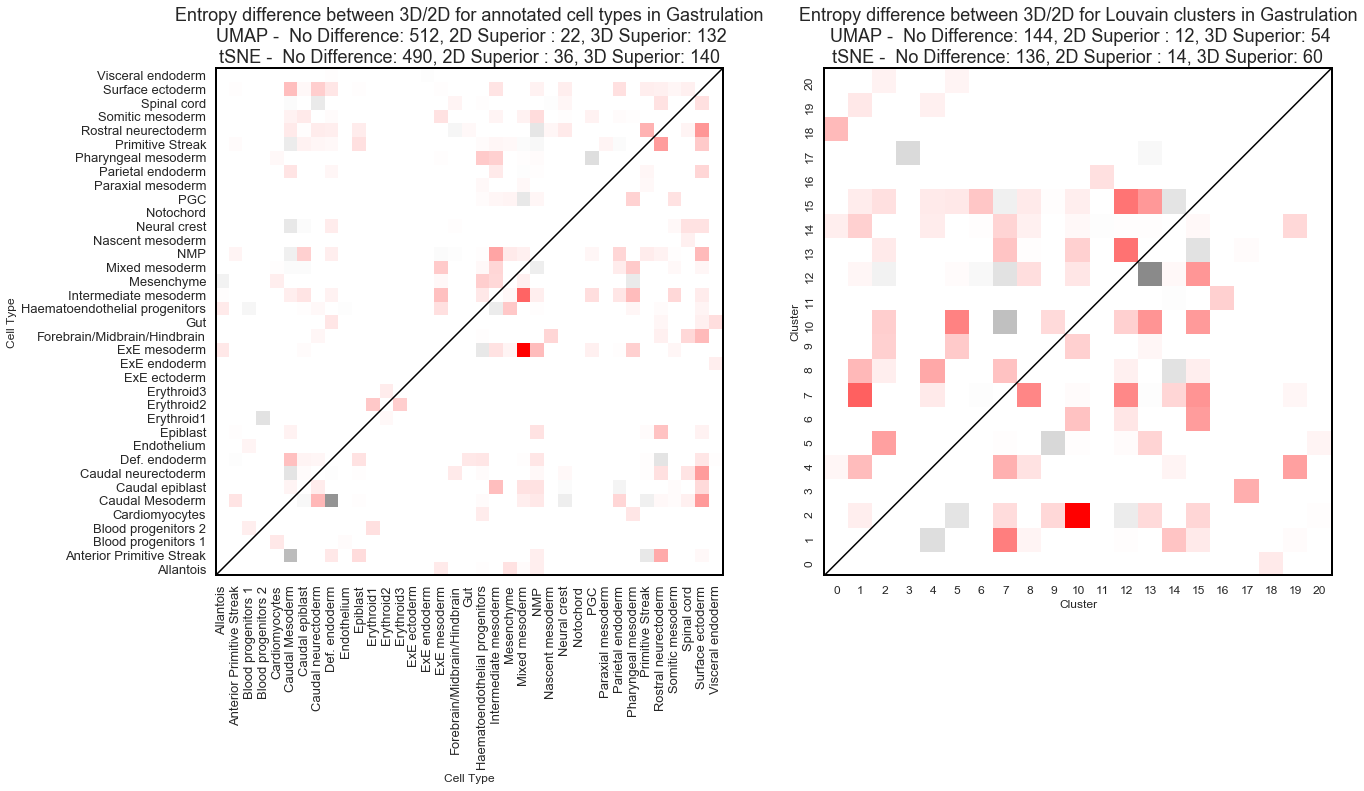

In [45]:
diff = get_differences("results/" + data + "_umap_celltypes_2d_entropies.csv", "results/" + data + "_umap_celltypes_3d_entropies.csv", celltypes_dict, fill_diagonal=False, index_offset=0)
diff2 = get_differences("results/" + data + "_tsne_celltypes_2d_entropies.csv", "results/" + data + "_tsne_celltypes_3d_entropies.csv", celltypes_dict, fill_diagonal=False, index_offset=0)

zeroes_diff = np.count_nonzero(np.array(diff == 0).flatten())
lt_diff = np.count_nonzero(np.array(diff < 0).flatten())
gt_diff = np.count_nonzero(np.array(diff > 0).flatten())

zeroes_diff2 = np.count_nonzero(np.array(diff2 == 0).flatten())
lt_diff2 = np.count_nonzero(np.array(diff2 < 0).flatten())
gt_diff2 = np.count_nonzero(np.array(diff2 > 0).flatten())

fig = plt.figure(figsize= (20,15))
ax = fig.add_subplot(121, facecolor=(1,1,1), frameon=True)
mine = np.nanmin(np.array(diff))
maxe = np.nanmax(np.array(diff))
extreme_value = max(abs(maxe), abs(mine))
diff_tot = (diff2.fillna(0).T + diff.fillna(0))
ax = sns.heatmap(diff_tot, xticklabels=celltypes_dict.values(), yticklabels=celltypes_dict.values(), vmin=-extreme_value, vmax=extreme_value,  square=True, cmap=cmap2, cbar=False)#, cmap=cmap)
#ax = sns.heatmap(diff, xticklabels=d_ct.values(), yticklabels=d_ct.values(), vmin=-extreme_value, vmax=extreme_value, square=True, cmap=cmap2, cbar=False)#cbar_kws={"shrink": 0.5})#, cmap=cmap)
ax.invert_yaxis()
ax.set_xlabel("Cell Type")
ax.set_ylabel("Cell Type")
ax.tick_params(axis='both', which='major', labelsize=13)
for _, spine in ax.spines.items():
    spine.set_color("black")
    spine.set_visible(True)
    spine.set_linewidth(2)
# draw diagonal
ax.plot((0,256), (0,256), c="black")
plt.title("Entropy difference between 3D/2D for annotated cell types in " + data.capitalize() + "\n "
          "UMAP -  No Difference: " + str(zeroes_diff) + ", 2D Superior : " + str(lt_diff) + ", 3D Superior: " + str(gt_diff) + "\n" +
          "tSNE -  No Difference: " + str(zeroes_diff2) + ", 2D Superior : " + str(lt_diff2) + ", 3D Superior: " + str(gt_diff2), fontsize=18)
print()

diff3 = get_differences("results/" + data + "_umap_louvain_2d_entropies.csv", "results/" + data + "_umap_louvain_3d_entropies.csv", clusters_dict, fill_diagonal=True, index_offset=0)
diff4 = get_differences("results/" + data + "_tsne_louvain_2d_entropies.csv", "results/" + data + "_tsne_louvain_3d_entropies.csv", clusters_dict, fill_diagonal=True, index_offset=0)

zeroes_diff = np.count_nonzero(np.array(diff3 == 0).flatten())
lt_diff = np.count_nonzero(np.array(diff3 < 0).flatten())
gt_diff = np.count_nonzero(np.array(diff3 > 0).flatten())

zeroes_diff2 = np.count_nonzero(np.array(diff4 == 0).flatten())
lt_diff2 = np.count_nonzero(np.array(diff4 < 0).flatten())
gt_diff2 = np.count_nonzero(np.array(diff4 > 0).flatten())


#fig = plt.figure(figsize= (30,20))
ax = fig.add_subplot(122, facecolor=(1,1,1), frameon=True)
mine = np.nanmin(np.array(diff3))
maxe = np.nanmax(np.array(diff3))
extreme_value2 = max(abs(maxe), abs(mine))
diff_tot = (diff4.fillna(0).T + diff3.fillna(0))
ax = sns.heatmap(diff_tot, xticklabels=clusters_dict.values(), yticklabels=clusters_dict.values(), vmin=-extreme_value2, vmax=extreme_value2, square=True, cmap=cmap2, cbar=False)# cbar_kws = dict(use_gridspec=False,location="left", shrink=0.5))

ax.invert_yaxis()
ax.set_xlabel("Cluster")
ax.set_ylabel("Cluster")
#plt.xticks(rotation=55)
ax.tick_params(axis='both', which='major', labelsize=12)
for _, spine in ax.spines.items():
    spine.set_color("black")
    spine.set_visible(True)
    spine.set_linewidth(2)
# draw diagonal
ax.plot((0,256), (0,256), c="black")
plt.title("Entropy difference between 3D/2D for Louvain clusters in " + data.capitalize() + "\n "
          "UMAP -  No Difference: " + str(zeroes_diff) + ", 2D Superior : " + str(lt_diff) + ", 3D Superior: " + str(gt_diff) + "\n" +
          "tSNE -  No Difference: " + str(zeroes_diff2) + ", 2D Superior : " + str(lt_diff2) + ", 3D Superior: " + str(gt_diff2), fontsize=18)
#plt.savefig("results/figures/heatmaps/diff_heatmap_louvain_" + data + ".png", bbox_inches='tight')

plt.savefig("results/figures/heatmaps/diff_heatmap_celltypes_" + data + ".png", bbox_inches='tight')

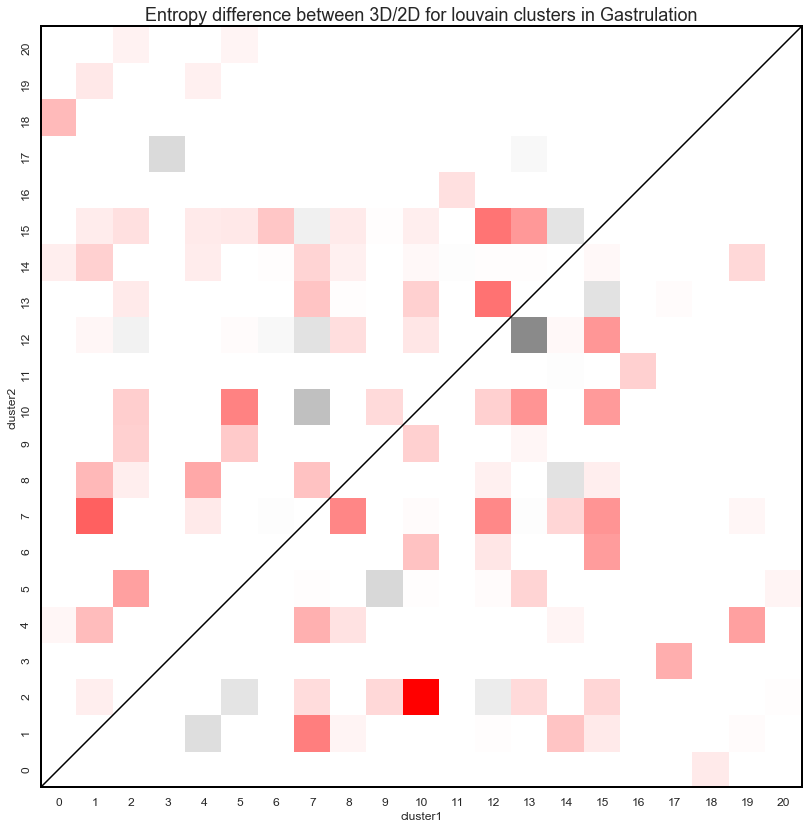

In [108]:
diff3 = get_differences("results/" + data + "_umap_louvain_2d_entropies.csv", "results/" + data + "_umap_louvain_3d_entropies.csv", clusters_dict, fill_diagonal=True, index_offset=0)
diff4 = get_differences("results/" + data + "_tsne_louvain_2d_entropies.csv", "results/" + data + "_tsne_louvain_3d_entropies.csv", clusters_dict, fill_diagonal=True, index_offset=0)

fig = plt.figure(figsize= (30,20))
ax = fig.add_subplot(121, facecolor=(1,1,1), frameon=True)
mine = np.nanmin(np.array(diff3))
maxe = np.nanmax(np.array(diff3))
extreme_value2 = max(abs(maxe), abs(mine))
diff_tot = (diff4.fillna(0).T + diff3.fillna(0))
ax = sns.heatmap(diff_tot, xticklabels=clusters_dict.values(), yticklabels=clusters_dict.values(), vmin=-extreme_value2, vmax=extreme_value2, square=True, cmap=cmap2, cbar=False)# cbar_kws = dict(use_gridspec=False,location="left", shrink=0.5))

ax.invert_yaxis()
#plt.xticks(rotation=55)
ax.tick_params(axis='both', which='major', labelsize=12)
for _, spine in ax.spines.items():
    spine.set_color("black")
    spine.set_visible(True)
    spine.set_linewidth(2)
# draw diagonal
ax.plot((0,256), (0,256), c="black")
plt.title("Entropy difference between 3D/2D for louvain clusters in " + data.capitalize(), fontsize=18)
plt.savefig("results/figures/heatmaps/diff_heatmap_louvain_" + data + ".png", bbox_inches='tight')

In [ ]:
np.count_nonzero(diff_tot == 0)

## Box/Violin plots

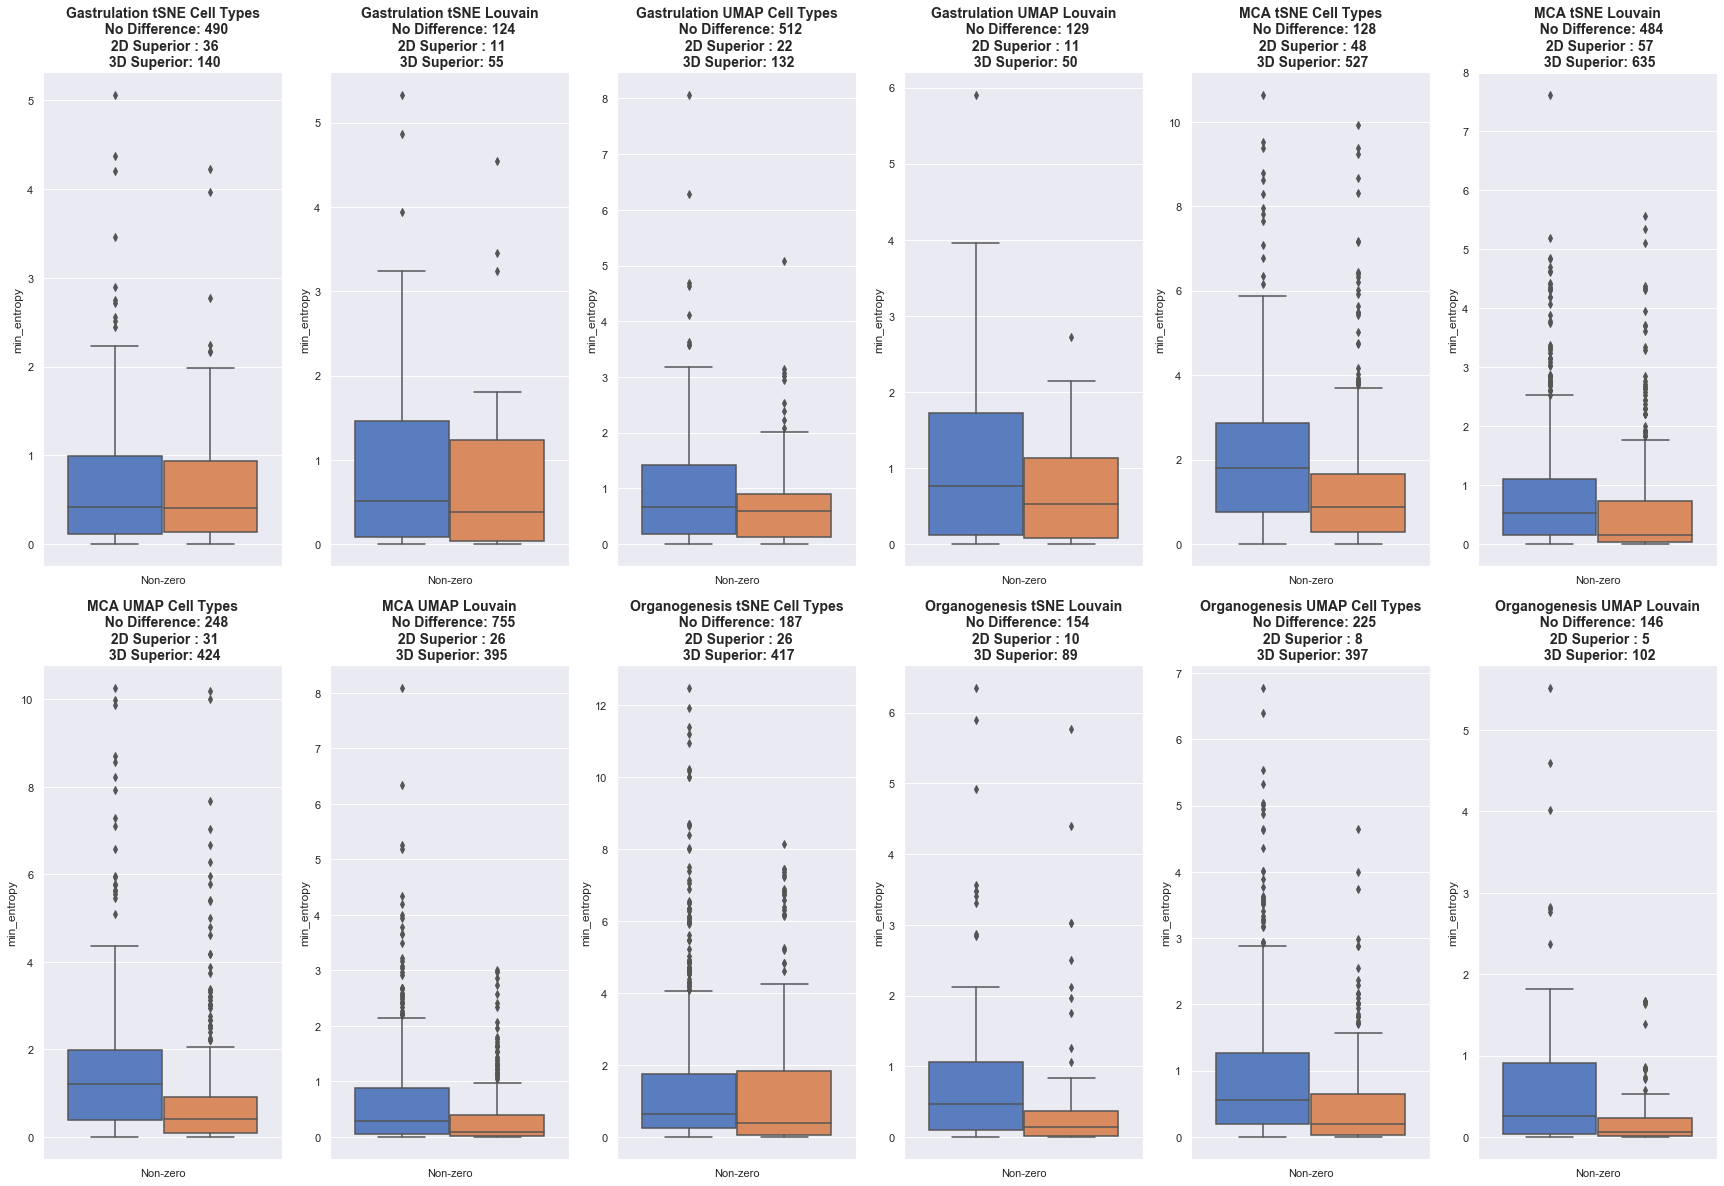

In [34]:
import glob

results = [f for f in glob.glob("results/" + "*.csv")]

paths2d = list(filter(lambda x : "2d" in x, results))
paths3d = list(filter(lambda x : "3d" in x, results))

fig = plot_multiple_boxplots(paths2d, paths3d)
plt.savefig("boxplots_entropy_legend.png", bbox_inches='tight')

## Colormap for Gastrulation figure

In [ ]:
gastru_cmap = ["#532C8A", "#c19f70", "#f9decf", "#c9a997", "#B51D8D", "#3F84AA", "#9e6762", "#354E23", "#F397C0", "#ff891c", "#635547", "#C72228", "#f79083", "#EF4E22", "#7F6874","#989898","#2f694d", "#647a4f","#EF5A9D", "#FBBE92",
               "#139992", "#cc7818","#f582d1","#8EC792","#C594BF","#C3C388",
                     "#0F4A9C",
                     "#FACB12",
                     "#8DB5CE",
                     "#1A1A1A",
                     "#C9EBFB",
                     "#DABE99",
                     "#65A83E",
                     "#CDE088",
                     "#005579",
                     "#f7f79e",
                     "#F6BFCB"
                     
              ]
gastru_cmap_exe_mixed = ["#2f694d", "#f582d1"]
#gastru_cmap = ListedColormap(gastru_cmap)

In [ ]:
gastru_cmap = {
    "Allantois" : "#532C8A",
    "Anterior Primitive Streak" : "#c19f70",
     "Blood progenitors 1" : "#f9decf",
     "Blood progenitors 2" : "#c9a997",
     "Cardiomyocytes" : "#B51D8D",
     "Caudal Mesoderm" : "#3F84AA",
    "Caudal epiblast" : "#9e6762",
                     "Caudal neurectoderm" : "#354E23",
                     "Def. endoderm" : "#F397C0",
                     "Endothelium" : "#ff891c",
                    "Epiblast" : "#635547",
                         "Erythroid1" : "#C72228",
                     "Erythroid2" : "#f79083",
                     "Erythroid3" : "#EF4E22",
                     "ExE ectoderm" : "#989898",
                         "ExE endoderm" : "#7F6874",
                     "ExE mesoderm" : "#88D0ad",
                     "Forebrain/Midbrain/Hindbrain" : "#647a4f",
                     "Gut" : "#EF5A9D",
                         "Haematoendothelial progenitors" : "#FBBE92",
    
                     "Intermediate mesoderm" : "#139992",
                         "Mesenchyme" : "#cc7818",
    
                     "Mixed mesoderm" : "#EFCDE4",
                     "NMP" : "#8EC792",
                     "Nascent mesoderm" : "#C594BF",
    
                     "Neural crest" : "#C3C388",
                         "Notochord" : "#0F4A9C",
                     "PGC" : "#FACB12",
                     "Paraxial mesoderm" : "#8DB5CE",
                     "Parietal endoderm" : "#1A1A1A"
    
                     "Pharyngeal mesoderm" : "#C9EBFB",
                     "Primitive Streak" : "#DABE99",
                     
                     "Rostral neurectoderm" : "#65A83E",

                     "Spinal cord" : "#CDE088",
                     "Somitic mesoderm" : "#005579",
                     "Surface ectoderm" : "#f7f79e",
                     "Visceral endoderm" : "#F6BFCB",
              }